In [1]:
import Pkg; 
Pkg.activate(@__DIR__); 
Pkg.instantiate()

  Activating environment at `~/Documents/PhD/courses/16745_optimal_control_rl/project/ballbot_ocrl_navigation/Project.toml`


In [2]:
using RigidBodyDynamics
using LinearAlgebra
using StaticArrays
using MeshCat
using MeshCatMechanisms
using ForwardDiff
using Plots
using RobotDynamics
using Ipopt
using FileIO, JLD2
using Colors
using ProgressMeter

import Random
import ECOS
import Convex as cvx
import MathOptInterface as MOI
import DifferentiableCollisions as dc
import MeshCat as mc;

WebIO._IJuliaInit()

In [3]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","ballbot_model.jl"))

rk4 (generic function with 1 method)

## Load ballbot model

In [4]:
ballbot_model = Ballbot_no_arms()

Ballbot{StateCache{Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}}(Spanning tree:
Vertex: world (root)
  Vertex: Link_Xtran, Edge: Joint_World_Xtran
    Vertex: Link_Ytran, Edge: Joint_World_Ytran
      Vertex: Link_Pitch, Edge: xAngle
        Vertex: Link_Roll, Edge: yAngle
          Vertex: Link_Yaw, Edge: yaw
No non-tree joints., StateCache{…}(…), DynamicsResultCache{Float64}(…), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

## Start visualizer

In [5]:
# Initialize visualizer
mvis = MechanismVisualizer(ballbot_model.mech, URDFVisuals(urdf))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MechanismVisualizer{MechanismState{Float64, Float64, Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}, Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat at http://127.0.0.1:8700, 12)

In [6]:
display(render(mvis))

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Xtran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x58, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Ytran" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x59, 0x74, 0x72, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Pitch" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x50, 0x69, 0x74, 0x63, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Roll" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x52, 0x6f, 0x6c, 0x6c], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("Link_Yaw" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6c, 0x2f, 0x4c, 0x69, 0x6e, 0x6b, 0x5f, 0x59, 0x61, 0x77], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_JBalltoBody" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x42, 0x61, 0x6c, 0x6c, 0x74, 0x6f, 0x42, 0x6f, 0x64, 0x79], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "after_turret_tilt" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x75, 0x72, 0x72, 0x65, 0x74, 0x5f, 0x74, 0x69, 0x6c, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_4" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x34], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "after_turret_pan" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x74, 0x75, 0x72, 0x72, 0x65, 0x74, 0x5f, 0x70, 0x61, 0x6e], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_3" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x33], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))))))), "after_Joint_World_Ball" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x57, 0x6f, 0x72, 0x6c, 0x64, 0x5f, 0x42, 0x61, 0x6c, 0x6c]

## Trajectory optimization

In [7]:
function create_idx(nx,nu,N) 
    # Our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # Constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x=x,u=u,c=c)
end


create_idx (generic function with 1 method)

In [8]:
function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # Input hermite simpson implicit integrator residual
    f1 = m_dynamics(ballbot_model, x1, u)
    f2 = m_dynamics(ballbot_model, x2, u)
    xm = 0.5*(x1 + x2) + (dt/8.0)*(f1 - f2)
    fm = m_dynamics(ballbot_model, xm, u)
    r = x1 + (dt/6.0)*(f1 + 4*fm + f2) - x2
    return r
end

hermite_simpson (generic function with 1 method)

In [9]:
function stage_cost(params,x,u,k)
    xref, uref = params.Xref, params.Uref
    Q = params.Q
    R = params.R
    return 0.5*((x-xref[k])'*Q*(x-xref[k])) + 0.5*(u-uref[k])'*R*(u-uref[k])
end

function terminal_cost(params,x)
    Qn = params.Qf
    xref = params.Xref
    return 0.5*((x-xref[end])'*Qn*(x-xref[end]))
end

terminal_cost (generic function with 1 method)

In [10]:
function ballbot_cost(params::NamedTuple, Z::Vector)::Real
    idx, N = params.idx, params.N 
    # Stage cost
    J = 0 
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += stage_cost(params, xi, ui, i)
    end
    
    # Terminal cost 
    xend = Z[idx.x[end]]
    J += terminal_cost(params, xend)
    return J 
end

ballbot_cost (generic function with 1 method)

In [11]:
function ballbot_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    c = zeros(eltype(Z), idx.nc)
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        # Apply hermite simpson 
        c[idx.c[i]] .= hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c
end

ballbot_dynamics_constraints (generic function with 1 method)

In [12]:
function ballbot_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N = params.idx, params.N 
    xg = params.xg
    xic = params.xic
    # Return all of the equality constraints 
    c = ballbot_dynamics_constraints(params, Z)
    c = [c; Z[idx.x[1]] - xic]
    c = [c; Z[idx.x[end]] - xg]

    return c
end

ballbot_equality_constraint (generic function with 1 method)

In [13]:
function ballbot_inequality_constraint(params, Z)
    return zeros(eltype(Z), 0)
end

ballbot_inequality_constraint (generic function with 1 method)

## Move from point A to point B

In [14]:
# Optimization Parameters
h = 0.1 #10 Hz
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 8.0 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*1 # position cost
diagq[3:4] = diagq[3:4]*1 # lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 10*Q
R = 0.5*diagm(ones(nu))

xic = zeros(nx)
xg = zeros(nx)
xg[1] = 8 # x-position
xg[2] = 8 # y-position

# Indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [15]:
# Create warm start trajectory
Xref = range(xic, xg, length = Nt)
Uref = [zeros(3) for i = 1:(Nt-1)];

In [16]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf);

In [17]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= -Inf*x_l[idx.x[i]]
    x_u[idx.x[i]] .= Inf*x_u[idx.x[i]]
    x_l[idx.u[i]] .= -Inf*x_l[idx.u[i]]
    x_u[idx.u[i]] .= Inf*x_u[idx.u[i]]
end

x_l[idx.x[end]] .= -Inf*x_l[idx.x[end]]
x_u[idx.x[end]] .= Inf*x_u[idx.x[end]]

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [18]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [19]:
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   861000
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian...

In [20]:
# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

In [21]:
#FileIO.save("utils/ballbot_X_straight.jld2","X_straight", X)
#FileIO.save("utils/ballbot_X_straight.jld2","U_straight", U)

In [22]:
Xm = hcat(X...)
Um = hcat(U...);

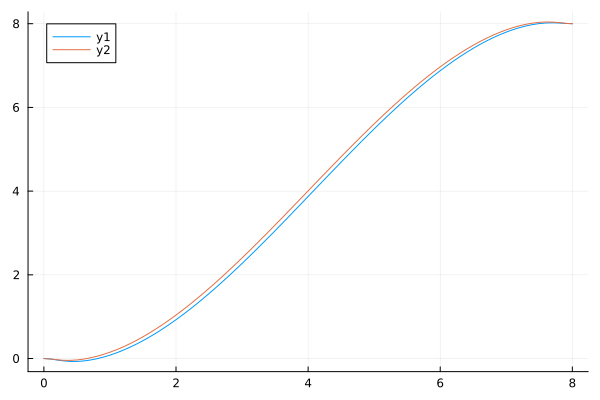

In [23]:
plot(thist,Xm[1,:])
plot!(thist,Xm[2,:])

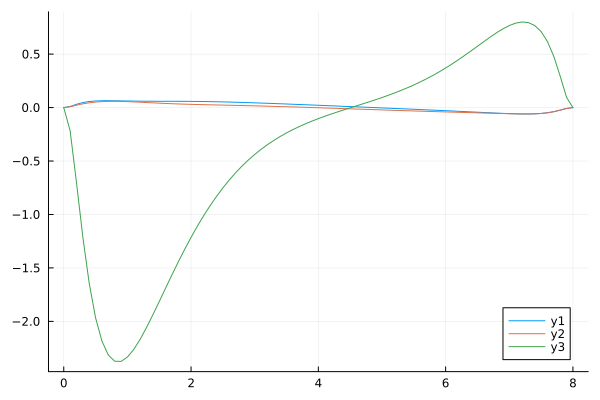

In [24]:
plot(thist,Xm[3,:])
plot!(thist,Xm[4,:])
plot!(thist,Xm[5,:])

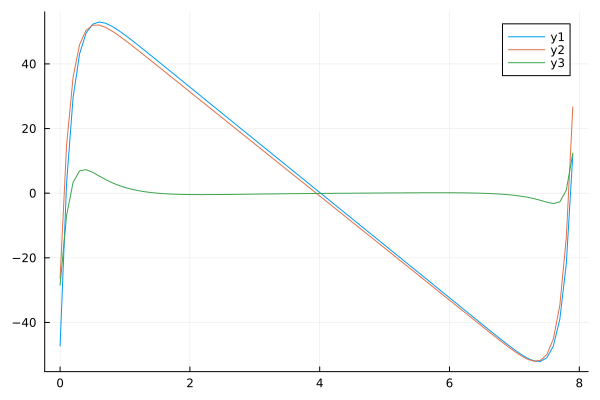

In [25]:
plot(thist[1:Nt-1],Um[1,:])
plot!(thist[1:Nt-1],Um[2,:])
plot!(thist[1:Nt-1],Um[3,:])

In [26]:
X1 = [SVector{5}(x[1:5]) for x in X];

In [27]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, thist, X1)
setanimation!(mvis, animation)

## Simulation

In [28]:
x0 = [0,0,0,0,0,0,0,0,0,0];

In [29]:
K_lqr = FileIO.load("utils/ballbot_K_lqr.jld2","K_lqr")

3×10 Matrix{Float64}:
 -65.9132     -0.341245  -1659.61     …  -340.457      -1.0455  -0.137694
  -0.346785  -55.6852       -4.29462       -1.05547  -309.247    4.14736
   1.17922   -35.123        14.8013         3.54713  -105.591    5.20419

In [30]:
# simulate closed loop system 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# initial condition 
Xsim[1] = 1*x0

# simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = U[i] - K_lqr*(Xsim[i] - X[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [31]:
Xc_sim = hcat(Xsim...)
Uc_sim = hcat(Usim...)

3×80 Matrix{Float64}:
 -47.2685   3.19773  29.5727   43.0789   …  -39.0037   -21.781     11.9434
 -26.3782  14.8688   35.8427   45.9355      -34.7141   -13.7732    26.6976
 -28.4557  -6.88393   3.35567   6.90964      -2.69458    0.933949  12.3908

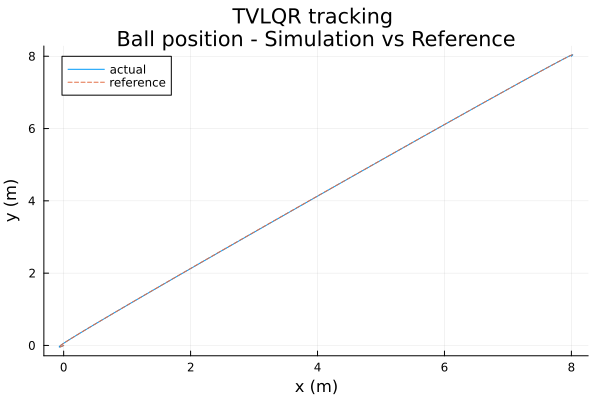

In [32]:
plot(Xc_sim[1,:], Xc_sim[2,:], label = "actual")
display(plot!(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "TVLQR tracking \n Ball position - Simulation vs Reference "))

In [33]:
error_x = Xm[1,:] - Xc_sim[1,:]
error_y = Xm[2,:] - Xc_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

0.0011826728719120615

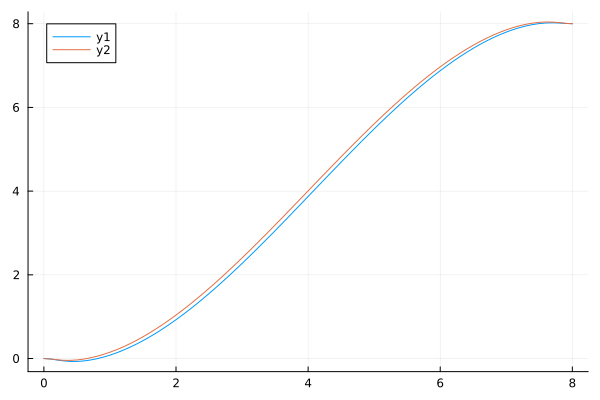

In [34]:
plot(thist,Xm[1,:])
plot!(thist,Xm[2,:])

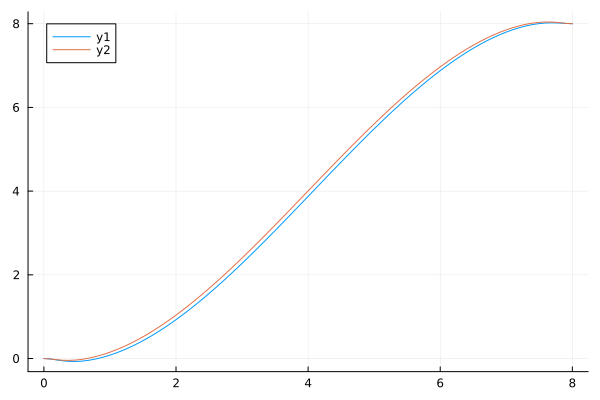

In [37]:
plot(thist,Xc_sim[1,:])
plot!(thist,Xc_sim[2,:])

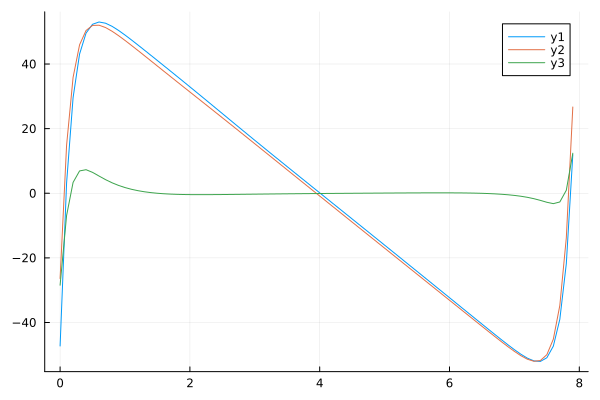

In [38]:
plot(thist[1:Nt-1],Uc_sim[1,:])
plot!(thist[1:Nt-1],Uc_sim[2,:])
plot!(thist[1:Nt-1],Uc_sim[3,:])

In [39]:
Xs = [SVector{5}(x[1:5]) for x in Xsim];

In [40]:
function vis_traj_line!(vis, name, X1; R = 0.1, color_1 = mc.RGBA(1.0, 0.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    for i = 1:length(X1)
        a = [X1[i][2]; -X1[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[:traj_ori]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color_1))
    end
end

vis_traj_line! (generic function with 1 method)

In [41]:
vis_traj_line!(mvis, :traj, X; R = 0.05, color_1 = mc.RGBA(0.0, 1.0, 0.0, 1.0))

In [42]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, thist, Xs)
setanimation!(mvis, animation)

## Create 8-shape trajectory

In [43]:
function create_infinity_shape_traj_t(t, i)
    scale = 20 ./ (3 .- cos.(2*t./i))
    x = scale.*cos.(t./i)
    y = scale.*sin.(2*t./i)/ 2
    return x, y
end

create_infinity_shape_traj_t (generic function with 1 method)

In [44]:
# Optimization Parameters
h = 1/3 #3 Hz
h = 0.1
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 25 # final time
Nt = Int(Tfinal/h)+1   # number of time steps
thist = Array(range(0,h*(Nt-1), step=h));
n_nlp = (nx+nu)*Nt # number of decision variables
m_nlp = nx*(Nt+1)

# Cost terms
diagq = ones(nx)
diagq[1:2] = diagq[1:2]*100 # position cost
diagq[3:4] = diagq[3:4]*10# lean angles cost

# Cost matrices
Q = diagm(diagq)
Qf = 100*Q
R = 0.1*diagm(ones(nu))

# indexing 
idx = create_idx(nx,nu,Nt);

diff_type = :auto

:auto

In [45]:
x, y = create_infinity_shape_traj_t(thist, 3.99);

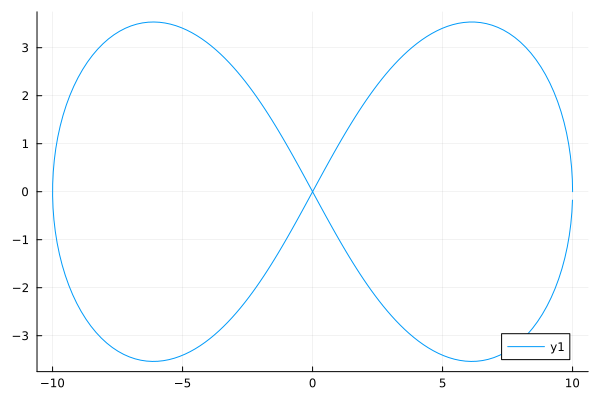

In [46]:
plot(x, y)

In [47]:
# Create warm start trajectory
Xref = [[x[i]; y[i]; zeros(8)] for i = 1:Nt]
Uref = [zeros(3) for i = 1:(Nt-1)];

In [48]:
xic =  Xref[1]
xg = Xref[end];

In [49]:
P_obs = [[4, 1.5], [-4, -2]]
r = 1

1

In [50]:
# Create params
params = (xic = xic,
          xg = xg,
          Xref = Xref,
          Uref = Uref,
          dt = h,
          N = Nt,
          idx = idx,
          Q = Q,
          R = R,
          Qf = Qf,
          P_obs = P_obs,
          r = r);

In [51]:
function ballbot_inequality_constraint_obs(params, Z)
    idx, N = params.idx, params.N 
    r = params.r
    P_obs = params.P_obs
    nobs = length(P_obs)
    d = zeros(eltype(Z), N*nobs)
    for i = 1:(N)
        xi = Z[idx.x[i]]
        xrob = xi[1:2]
        # DONE: hermite simpson 
        for j = 1:nobs
            xobs = P_obs[j]
            if norm(xrob - xobs)^2  < 2*r^2
                d[(i-1)*nobs+j] = r^2 - norm(xrob - xobs)^2
            else
                d[(i-1)*nobs+j] = 0
            end
        end
    end
    return d
end

ballbot_inequality_constraint_obs (generic function with 1 method)

In [52]:
# Primal bounds 
x_l = ones(idx.nz)
x_u = ones(idx.nz)

for i = 1:(Nt-1)
    x_l[idx.x[i]] .= -Inf*x_l[idx.x[i]]
    #x_l[idx.x[i]][3:4] .= -0.2*x_l[idx.x[i]][3:4]
    
    x_u[idx.x[i]] .= Inf*x_u[idx.x[i]]
    #x_u[idx.x[i]][3:4] .= 0.2*x_u[idx.x[i]][3:4]
    
    x_l[idx.u[i]] .= -Inf*x_l[idx.u[i]]
    x_u[idx.u[i]] .= Inf*x_u[idx.u[i]]
end

x_l[idx.x[end]] .= -Inf*x_l[idx.x[end]]
x_u[idx.x[end]] .= Inf*x_u[idx.x[end]]


nobs = length(P_obs)
# Inequality constraint bounds (this is what we do when we have no inequality constraints)
#c_l = -Inf*ones(Nt*nobs)
#c_u = zeros(Nt*nobs)

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l = zeros(0)
c_u = zeros(0)

verbose=true

true

In [53]:
z0 = zeros(idx.nz)
for i in 1:(Nt-1)
    z0[idx.x[i]] .= Xref[i]
    z0[idx.u[i]] .= Uref[i]
end
z0[idx.x[end]] .= Xref[end];

In [ ]:
# Uncomment to run optimization
Z = fmincon(ballbot_cost,ballbot_equality_constraint,ballbot_inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);

# Pull the X and U solutions out of Z 
X = [Z[idx.x[i]] for i = 1:Nt]
U = [Z[idx.u[i]] for i = 1:(Nt-1)];

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----


In [ ]:
# Save references
#FileIO.save("utils/ballbot_Xref_8_3.3Hz.jld2","Xref_8_3.3Hz", X)
#FileIO.save("utils/ballbot_Uref_8_3.3Hz.jld2","Uref_8_3.3Hz", U)

In [ ]:
# Select reference trajectory
#Xref_trajop = FileIO.load("utils/ballbot_Xref_8_less.jld2","Xref_8_less")
#Uref_trajop = FileIO.load("utils/ballbot_Uref_8_less.jld2","Uref_8_less");

#Xref_trajop = FileIO.load("utils/ballbot_Xref_8_2.jld2","Xref_8_2")
#Uref_trajop = FileIO.load("utils/ballbot_Uref_8_2.jld2","Uref_8_2");

#Xref_trajop = FileIO.load("utils/ballbot_Xref_8_3Hz.jld2","Xref_8_3Hz")
#Uref_trajop = FileIO.load("utils/ballbot_Uref_8_3Hz.jld2","Uref_8_3Hz");

Xref_trajop = FileIO.load("utils/ballbot_Xref_8_3.3Hz.jld2","Xref_8_3.3Hz")
Uref_trajop = FileIO.load("utils/ballbot_Xref_8_3.3Hz.jld2","Uref_8_3.3Hz");

#Xref_trajop = X*1 # Current trajectory
#Uref_trajop = U*1; # Current trajectory

In [ ]:
Xm = hcat(Xref_trajop...)
Um = hcat(Uref_trajop...);

In [ ]:
plot(thist,Xm[1,:])
plot!(thist,Xm[2,:])

In [ ]:
plot(Xm[1,:],Xm[2,:])

In [ ]:
plot(thist,Xm[3,:])
plot!(thist,Xm[4,:])

In [ ]:
plot(thist[1:Nt-1],Um[1,:])
plot!(thist[1:Nt-1],Um[2,:])
plot!(thist[1:Nt-1],Um[3,:])

In [ ]:
X1 = [SVector{5}(x[1:5]) for x in X];

In [ ]:
# Uncomment for upload animation to visualizer
#animation = mc.Animation(mvis, thist, X1)
#setanimation!(mvis, animation)

# Simulation

### TVLQR

In [ ]:
function tvlqr(model,
               dt,
               Xbar,
               Ubar,
               Q::Matrix, # cost weight 
               R::Matrix, # cost weight 
               Qf::Matrix,# term cost weight 
               N::Int64   # horizon size 
               )::Tuple{Vector{Matrix{Float64}}, Vector{Matrix{Float64}}} # return two matrices 
        
    # check sizes of everything 
    nx = length(Xbar[1])
    nu = length(Ubar[1])
  
    @assert size(Q) == (nx, nx)
    @assert size(R) == (nu, nu)
    @assert size(Qf) == (nx, nx)
        
    # instantiate S and K 
    P = [zeros(nx,nx) for i = 1:N]
    K = [zeros(nu,nx) for i = 1:N-1]
    
    # initialize S[N] with Qf 
    P[N] = deepcopy(Qf)
    
    # Ricatti 
    for k = (N-1):-1:1
        A = ForwardDiff.jacobian(x->rk4(model, x, Ubar[k], dt), Xbar[k]);
        B = ForwardDiff.jacobian(u->rk4(model, Xbar[k], u, dt), Ubar[k]);
        K[k] = (R + B'*P[k+1]*B)\(B'*P[k+1]*A)
        P[k] = Q + A'*P[k+1]*(A-B*K[k]) 
    end
    
    return P, K 
end

In [ ]:
_, K_tvlqr = tvlqr(ballbot_model, h, Xref_trajop, Uref_trajop, Q, R, Qf, Nt);

In [ ]:
#FileIO.save("utils/ballbot_tvlqr_8.jld2","tvlqr_8", U)

In [ ]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(Xsim[i] - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [ ]:
Xc_sim = hcat(Xsim...)
Uc_sim = hcat(Usim...)

In [ ]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    x_estimated = Xsim[i]*1
    #x_estimated[1:2] .= x_estimated[1:2] + 0.005*randn(2)
    #x_estimated[6:7] .= x_estimated[6:7] + 0.005*randn(2)
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(x_estimated - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_real_model, x_estimated, Usim[i], h)
end

In [ ]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

In [ ]:
#plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual + 10% body mass increase + random gaussian noise")
plot(Xc_sim[1,:], Xc_sim[2,:], label = "actual")
display(plot!(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "TVLQR tracking \n Ball position - Simulation vs Reference "))

In [ ]:
error_x = Xm[1,:] - Xc_sim[1,:]
error_y = Xm[2,:] - Xc_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

In [ ]:
error_x = Xm[1,:] - Xm_sim[1,:]
error_y = Xm[2,:] - Xm_sim[2,:]
sum(sqrt.(error_x.^2 + error_y.^2))/length(error_x)

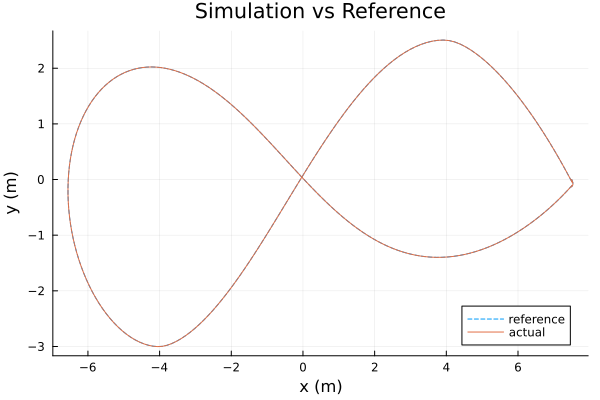

In [365]:
plot(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
display(plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual"))

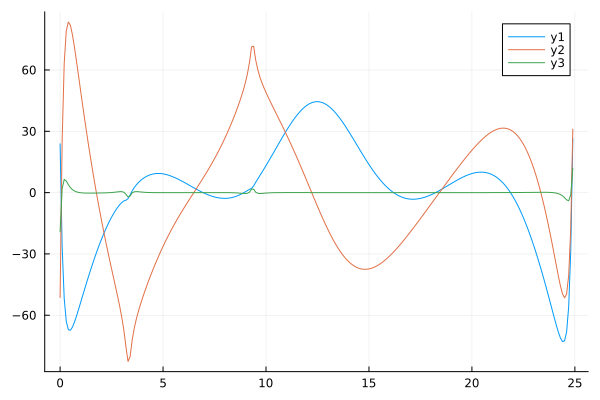

In [366]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot!(thist[1:Nt-1],Um_sim[2,:])
plot!(thist[1:Nt-1],Um_sim[3,:])

In [200]:
x0 = Xref_trajop[1];

# Initialize simulation 
Xsim = [zeros(nx) for i = 1:Nt]
Usim = [zeros(nx) for i = 1:(Nt-1)]

# Initial condition 
Xsim[1] = 1*x0

# Simulate with closed loop control 
for i = 1:(Nt-1) 
    Usim[i] = Uref_trajop[i] - K_tvlqr[i]*(Xsim[i] + 0.01*randn(nx) - Xref_trajop[i])
    Xsim[i+1] = rk4(ballbot_model, Xsim[i], Usim[i], h)
end

In [201]:
Xm_sim = hcat(Xsim...)
Um_sim = hcat(Usim...)

3×250 Matrix{Float64}:
  28.4275  -29.0648   -75.1751   -53.058    …  -51.8368   -31.1473   25.0229
 -38.4962    6.1249    55.8235    70.0511      -40.0964   -11.7621   32.0602
 -16.031    -3.36297    2.12026    8.33437      -6.21613   -1.14437  11.7321

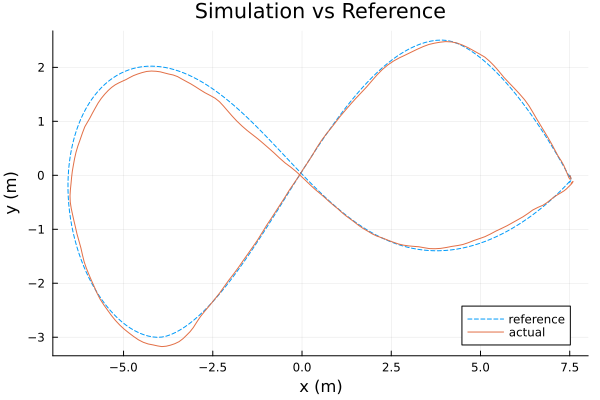

In [202]:
plot(Xm[1,:], Xm[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
display(plot!(Xm_sim[1,:], Xm_sim[2,:], label = "actual"))

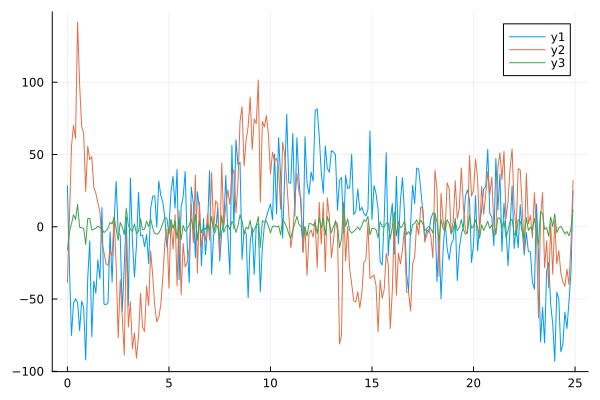

In [203]:
plot(thist[1:Nt-1],Um_sim[1,:])
plot!(thist[1:Nt-1],Um_sim[2,:])
plot!(thist[1:Nt-1],Um_sim[3,:])

In [376]:
Xs = [SVector{5}(x[1:5]) for x in Xsim];

In [369]:
function vis_traj!(vis, name, X1, X2; R = 0.1, color_1 = mc.RGBA(1.0, 0.0, 0.0, 1.0), color_2 = mc.RGBA(0.0, 1.0, 0.0, 1.0))
    # visualize a trajectory expressed with X::Vector{Vector}
    #for i = 1:(length(X)-1)
    #    a = [X[i][2]; -X[i][1]; 0.0]
    #    b = [X[i][2]; -X[i+1][1]; 0.0]
    #    cyl = mc.Cylinder(mc.Point(b...), mc.Point(a...), R)
    #    mc.setobject!(vis[name]["p"*string(i)], cyl, mc.MeshPhongMaterial(color=color))
    #end
    for i = 1:length(X2)
        a = [X2[i][2]; -X2[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[name]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color_2))
    end
    
    for i = 1:length(X1)
        a = [X1[i][2]; -X1[i][1]; 0.0]
        sph = mc.HyperSphere(mc.Point(a...), R)
        mc.setobject!(vis[:traj_ori]["s"*string(i)], sph, mc.MeshPhongMaterial(color=color_1))
    end
end

vis_traj! (generic function with 1 method)

In [370]:
#delete!(mvis)
mvis_obs = MechanismVisualizer(ballbot_model.mech, URDFVisuals(urdf))

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8723


MechanismVisualizer{MechanismState{Float64, Float64, Float64, TypeSortedCollections.TypeSortedCollection{Tuple{Vector{Joint{Float64, Prismatic{Float64}}}, Vector{Joint{Float64, Revolute{Float64}}}}, 2}}, Visualizer}(MechanismState{Float64, Float64, Float64, …}(…), MeshCat Visualizer with path /meshcat at http://127.0.0.1:8723, 12)

In [371]:
Xref_no_obs = FileIO.load("utils/ballbot_Xref_8_3Hz.jld2","Xref_8_3Hz")
#Uref_no_obs = FileIO.load("utils/ballbot_Uref_8_3Hz.jld2","Uref_8_3Hz");

In [372]:
vis_traj!(mvis_obs, :traj, Xref_trajop, Xref_no_obs; R = 0.05, color_1 = mc.RGBA(1.0, 0.0, 0.0, 1.0), color_2 = mc.RGBA(0.0, 1.0, 0.0, 1.0))

## Add obstacles

In [373]:
P_bot = dc.create_rect_prism(1.0, 1.0, 1.0)[1]
P_bot.r = [1.5,-4,0.5]
P_top = dc.create_rect_prism(1.0, 1.0, 1.0)[1]
P_top.r = [-2,4,0.5]

P_vic = dc.CylinderMRP(0.2,1.7)
P_vic.r = [0,0,0.85]

P_obs_dc = [P_bot, P_top, P_vic];

In [374]:
coll = Random.shuffle(range(HSVA(0,0.5,.75,1.0), stop=HSVA(-360,0.5,.75,1.0), length=9))
for i = 1:2
    name = "P" * string(i)
    dc.build_primitive!(mvis_obs, P_obs_dc[i], name; α = 1.0,color = coll[i])
    dc.update_pose!(mvis_obs[name], P_obs_dc[i])
end

In [377]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis_obs, thist, Xs)
setanimation!(mvis_obs, animation)

# MPC

In [181]:
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)

    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))
    Qf = 1*Q
    
    # Variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    # Implement cost
    obj = 0 
    for k = 1:(N_mpc-1)
        obj += 0.5*cvx.quadform(X[:,k] - X_ref_window[k], Q)
        obj += 0.5*cvx.quadform(U[:,k], R)
    end

    xn = X[:,N_mpc]
    obj += 0.5*cvx.quadform(xn - X_ref_window[N_mpc], Qf)
    
    # Create problem with objective
    prob = cvx.minimize(obj)

    # Add constraints with prob.constraints += 
    prob.constraints += X[:,1] == xic
    
    for k = 1:(N_mpc-1)
        # Dynamics constraints
        prob.constraints += (X[:,k+1] == A*X[:,k] + B*U[:,k])
    end

    for k = 1:(N_mpc-1)
        # U tolerance constraints
        prob.constraints += (U[:,k] >= u_min)
        prob.constraints += (U[:,k] <= u_max)
    end
    
    # Solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)
    
    # Get X and U solutions 
    X = X.value
    U = U.value
    
    # Return first control U 
    return U[:,1]
end

convex_mpc (generic function with 2 methods)

In [232]:
# create our discrete time model 
dt = 0.1
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls

# initial and goal states
x0 = Xref_trajop[1]*1
xg = Xref_trajop[end]*1

# bounds on U
u_max = 100*ones(3)
u_min = -u_max

# MPC window size 
N_mpc = 20 

# Problem size and reference trajectory 
N = Nt*1 
t_vec = 0:dt:((N-1)*dt)
X_ref = [Xref_trajop*1...,[xg for i = 1:2*N_mpc]...]
U_ref = [Uref_trajop*1...,[zeros(3) for i = 1:2*N_mpc]...]

# sim size and setup 
N_sim = N + N_mpc 
t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = x0 
U_sim = [zeros(nu) for i = 1:(N_sim-1)]

# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    # Given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    #U_ref_tilde = U_ref[i:i+N_mpc-1]
    u_lin = zeros(3)
    #u_lin = U_ref_tilde[1]
    x_lin = X_ref_tilde[1]
    A = ForwardDiff.jacobian(x->rk4(ballbot_model, x, u_lin, h), x_lin);
    B = ForwardDiff.jacobian(u->rk4(ballbot_model, x_lin, u, h), u_lin);
    # Call convex mpc controller with state estimate 
    U_sim[i] = convex_mpc(A, B, X_ref_tilde, X_sim[i], u_min, u_max, N_mpc)
    # Simulate one step 
    X_sim[i+1] = rk4(ballbot_model, X_sim[i], U_sim[i], h)
end

simulating   1%|▎                                        |  ETA: 2:46:17┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating   3%|█▏                                       |  ETA: 0:46:47┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating   3%|█▍                                       |  ETA: 0:36:09┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating   4%|█▋                                       |  ETA: 0:29:26┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating   5%|██                                  

┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  16%|██████▋                                  |  ETA: 0:06:34┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  17%|███████▏                                 |  ETA: 0:06:05┌ Warning: Problem status ALMOST_OPTIMAL; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status NUMERICAL_ERROR; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  18%|███████▌                               

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  30%|████████████▏                            |  ETA: 0:03:07┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  31%|████████████▋                            |  ETA: 0:02:57┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Probl

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  43%|█████████████████▋                       |  ETA: 0:01:46┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  44%|██████████████████▏                      |  ETA: 0:01:42┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Probl

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  57%|███████████████████████▎                 |  ETA: 0:01:02┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  58%|███████████████████████▉                 |  ETA: 0:00:59┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Probl

┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  70%|████████████████████████████▉            |  ETA: 0:00:35┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  71%|█████████████████████████████▎           |  ETA: 0:00:33┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Probl

simulating  85%|██████████████████████████████████▊      |  ETA: 0:00:15┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating  86%|███████████████████████████████████▍     |  ETA: 0:00:13┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Probl

simulating  98%|████████████████████████████████████████▎|  ETA: 0:00:02┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating 100%|████████████████████████████████████████▉|  ETA: 0:00:00┌ Warning: Problem status ALMOST_DUAL_INFEASIBLE; solution may be inaccurate.
└ @ Convex ~/.julia/packages/Convex/tSTAW/src/solution.jl:342
simulating 100%|█████████████████████████████████████████| Time: 0:01:25


In [233]:
Xmpc_sim = hcat(X_sim...)
Umpc_sim = hcat(U_sim...);

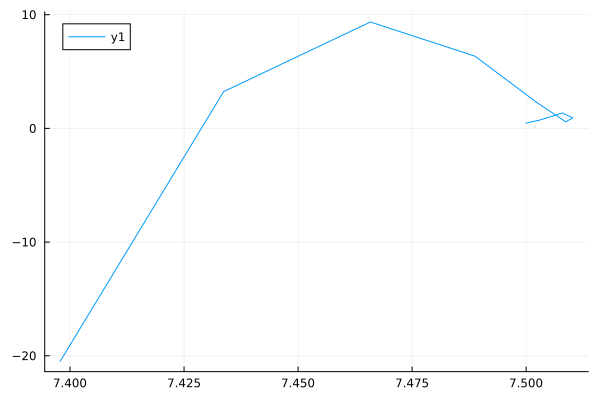

In [234]:
plot(Xmpc_sim[1,1:10], Umpc_sim[2,1:10])

# Nonconvex MPC

In [299]:
function non_convex_mpc(params,
                        xic,
                        X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                        U_ref_window::Vector{Vector{Float64}},
                        z0_window::Vector, # current state x 
                        N_mpc::Int64  # length of MPC window (horizon)
                        )::Vector{Float64} # return the first control command of the solved policy 
    idx = params.idx
    xg = X_ref_window[end]
    new_params = (xic = xic,
                  xg = xg,
                  Xref = X_ref_window,
                  Uref = U_ref_window,
                  dt =  params.dt,
                  N = N_mpc,
                  idx = idx,
                  Q =  params.Q,
                  R =  params.R,
                  Qf =  params.Qf,
                  P_obs =  params.P_obs,
                  r =  params.r);
    #println("New params")
    Z_window = fmincon(ballbot_cost,
                       ballbot_equality_constraint,
                       ballbot_inequality_constraint,
                       x_l_mpc,x_u_mpc,c_l_mpc,c_u_mpc,
                       z0_window,new_params, diff_type;
                       tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);    
    # Return first control U 
    return Z_window[idx.u[1]]
end

non_convex_mpc (generic function with 2 methods)

In [195]:
# Optimization Parameters
dt = 0.1 # 10 Hz
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 25 # final time
N = Int(Tfinal/h)+1   # number of time steps

# MPC window size 
N_mpc = 10 

# Cost matrices
Q = diagm(diagq)
Qf = 1*Q
R = 0.1*diagm(ones(nu))

# indexing 
idx_mpc = create_idx(nx,nu,N_mpc);

In [313]:
# Primal bounds 
x_l_mpc = -Inf*ones(idx_mpc.nz)
x_u_mpc = Inf*ones(idx_mpc.nz)

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
c_l_mpc = zeros(0)
c_u_mpc = zeros(0)

verbose=true

true

In [320]:
# initial and goal states
x0 = Xref_trajop[1]*1
xg = Xref_trajop[end]*1

# Problem size and reference trajectory 
t_vec = 0:dt:((N-1)*dt)
X_ref = [Xref_trajop*1...,[xg for i = 1:2*N_mpc]...]
U_ref = [Uref_trajop*1...,[zeros(3) for i = 1:2*N_mpc]...]

# sim size and setup 
N_sim = N + N_mpc 
t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = x0 
U_sim = [zeros(nu) for i = 1:(N_sim-1)]

# Create params
params_mpc = (xic = x0,
              xg = xg,
              Xref = Xref,
              Uref = Uref,
              dt = h,
              N = N,
              idx = idx_mpc,
              Q = Q,
              R = R,
              Qf = Qf,
              P_obs = P_obs,
              r = r);

# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    # Given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    U_ref_tilde = U_ref[i:i+N_mpc-1]
    z_0_w = zeros(idx_mpc.nz)
    for i in 1:(N_mpc-1)
        z_0_w[idx_mpc.x[i]] .= X_ref_tilde[i]
        z_0_w[idx_mpc.u[i]] .= U_ref_tilde[i]
    end
    z_0_w[idx_mpc.x[end]] .= X_ref_tilde[end];
    
    # Call non convex mpc controller with state estimate 
    #println("Non-convex MPC")
    U_sim[i] = non_convex_mpc(params_mpc, X_sim[i]+ 0.01*randn(nx), X_ref_tilde, U_ref_tilde, z_0_w, N_mpc)
    # Simulate one step 
    X_sim[i+1] = rk4(ballbot_model, X_sim[i], U_sim[i], h)
end

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints.......

simulating   1%|▍                                        |  ETA: 0:00:51

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.63e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   1%|▌                                        |  ETA: 0:01:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.57e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   2%|▋                                        |  ETA: 0:01:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.88e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   2%|▊                                        |  ETA: 0:01:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.04e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   2%|█                                        |  ETA: 0:01:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   3%|█▏                                       |  ETA: 0:01:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.98e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   3%|█▎                                       |  ETA: 0:01:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.35e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   3%|█▍                                       |  ETA: 0:01:31

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.68e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   4%|█▋                                       |  ETA: 0:01:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.87e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   4%|█▊                                       |  ETA: 0:01:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.40e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   5%|█▉                                       |  ETA: 0:01:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.18e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   5%|██                                       |  ETA: 0:01:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.69e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   5%|██▎                                      |  ETA: 0:01:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.21e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   6%|██▍                                      |  ETA: 0:01:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.34e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   6%|██▌                                      |  ETA: 0:01:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.51e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   7%|██▋                                      |  ETA: 0:01:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.24e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   7%|██▉                                      |  ETA: 0:01:20

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.29e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   7%|███                                      |  ETA: 0:01:19

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.93e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   8%|███▏                                     |  ETA: 0:01:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   8%|███▎                                     |  ETA: 0:01:19

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   8%|███▌                                     |  ETA: 0:01:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.10e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   9%|███▋                                     |  ETA: 0:01:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.26e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   9%|███▊                                     |  ETA: 0:01:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.43e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  10%|████                                     |  ETA: 0:01:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.54e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  10%|████▏                                    |  ETA: 0:01:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.91e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  10%|████▎                                    |  ETA: 0:01:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.00e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  11%|████▍                                    |  ETA: 0:01:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.52e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  11%|████▋                                    |  ETA: 0:01:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.17e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  12%|████▊                                    |  ETA: 0:01:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.12e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  12%|████▉                                    |  ETA: 0:01:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.02e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  12%|█████                                    |  ETA: 0:01:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.11e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  13%|█████▎                                   |  ETA: 0:01:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  13%|█████▍                                   |  ETA: 0:01:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.49e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  13%|█████▌                                   |  ETA: 0:01:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.22e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  14%|█████▋                                   |  ETA: 0:01:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.52e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  14%|█████▉                                   |  ETA: 0:01:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.63e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  15%|██████                                   |  ETA: 0:01:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.46e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  15%|██████▏                                  |  ETA: 0:01:12

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.71e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  15%|██████▎                                  |  ETA: 0:01:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.57e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  16%|██████▌                                  |  ETA: 0:01:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.69e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  16%|██████▋                                  |  ETA: 0:01:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.31e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  17%|██████▊                                  |  ETA: 0:01:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.32e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  17%|███████                                  |  ETA: 0:01:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.89e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  17%|███████▏                                 |  ETA: 0:01:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.05e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  18%|███████▎                                 |  ETA: 0:01:08

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.39e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  18%|███████▍                                 |  ETA: 0:01:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.36e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  18%|███████▋                                 |  ETA: 0:01:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.21e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  19%|███████▊                                 |  ETA: 0:01:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.26e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  19%|███████▉                                 |  ETA: 0:01:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.10e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  20%|████████                                 |  ETA: 0:01:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.70e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  20%|████████▎                                |  ETA: 0:01:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.08e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  20%|████████▍                                |  ETA: 0:01:04

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.05e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  21%|████████▌                                |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.73e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  21%|████████▋                                |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.69e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  22%|████████▉                                |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.84e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  22%|█████████                                |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.75e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  22%|█████████▏                               |  ETA: 0:01:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.88e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  23%|█████████▎                               |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  23%|█████████▌                               |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.18e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  23%|█████████▋                               |  ETA: 0:01:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.30e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  24%|█████████▊                               |  ETA: 0:01:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.85e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  24%|█████████▉                               |  ETA: 0:01:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.28e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  25%|██████████▏                              |  ETA: 0:01:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.67e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  25%|██████████▎                              |  ETA: 0:01:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.94e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  25%|██████████▍                              |  ETA: 0:01:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.58e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  26%|██████████▋                              |  ETA: 0:01:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.22e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  26%|██████████▊                              |  ETA: 0:01:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.75e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  27%|██████████▉                              |  ETA: 0:01:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.73e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  27%|███████████                              |  ETA: 0:01:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.01e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  27%|███████████▎                             |  ETA: 0:01:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.04e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  28%|███████████▍                             |  ETA: 0:01:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.62e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  28%|███████████▌                             |  ETA: 0:01:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.11e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  28%|███████████▋                             |  ETA: 0:00:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.08e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  29%|███████████▉                             |  ETA: 0:00:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.24e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  29%|████████████                             |  ETA: 0:00:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.73e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  30%|████████████▏                            |  ETA: 0:00:58

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.54e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  30%|████████████▎                            |  ETA: 0:00:58

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.61e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  30%|████████████▌                            |  ETA: 0:00:58

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  31%|████████████▋                            |  ETA: 0:00:58

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.56e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  31%|████████████▊                            |  ETA: 0:00:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.92e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  32%|████████████▉                            |  ETA: 0:00:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.57e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  32%|█████████████▏                           |  ETA: 0:00:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.11e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  32%|█████████████▎                           |  ETA: 0:00:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.87e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  33%|█████████████▍                           |  ETA: 0:00:56

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.35e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  33%|█████████████▌                           |  ETA: 0:00:56

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.64e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  33%|█████████████▊                           |  ETA: 0:00:56

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.83e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  34%|█████████████▉                           |  ETA: 0:00:55

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.09e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  34%|██████████████                           |  ETA: 0:00:55

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.73e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  35%|██████████████▎                          |  ETA: 0:00:55

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.87e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  35%|██████████████▍                          |  ETA: 0:00:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.40e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  35%|██████████████▌                          |  ETA: 0:00:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  36%|██████████████▋                          |  ETA: 0:00:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.25e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  36%|██████████████▉                          |  ETA: 0:00:53

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.33e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  37%|███████████████                          |  ETA: 0:00:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.08e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  37%|███████████████▏                         |  ETA: 0:00:53

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.40e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  37%|███████████████▎                         |  ETA: 0:00:53

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.26e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  38%|███████████████▌                         |  ETA: 0:00:52

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.76e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  38%|███████████████▋                         |  ETA: 0:00:52

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.64e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  38%|███████████████▊                         |  ETA: 0:00:52

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.60e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  39%|███████████████▉                         |  ETA: 0:00:51

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.17e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  39%|████████████████▏                        |  ETA: 0:00:51

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  40%|████████████████▎                        |  ETA: 0:00:51

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.45e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  40%|████████████████▍                        |  ETA: 0:00:50

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.17e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  40%|████████████████▌                        |  ETA: 0:00:50

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.30e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  41%|████████████████▊                        |  ETA: 0:00:50

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.27e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  41%|████████████████▉                        |  ETA: 0:00:50

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.01e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  42%|█████████████████                        |  ETA: 0:00:49

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.67e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  42%|█████████████████▎                       |  ETA: 0:00:49

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.76e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  42%|█████████████████▍                       |  ETA: 0:00:49

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.60e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  43%|█████████████████▌                       |  ETA: 0:00:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.65e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  43%|█████████████████▋                       |  ETA: 0:00:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.73e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  43%|█████████████████▉                       |  ETA: 0:00:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.88e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  44%|██████████████████                       |  ETA: 0:00:47

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  44%|██████████████████▏                      |  ETA: 0:00:47

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.44e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  45%|██████████████████▎                      |  ETA: 0:00:46

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.68e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  45%|██████████████████▌                      |  ETA: 0:00:46

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.81e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  45%|██████████████████▋                      |  ETA: 0:00:46

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.91e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  46%|██████████████████▊                      |  ETA: 0:00:46

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.44e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  46%|██████████████████▉                      |  ETA: 0:00:45

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.37e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  47%|███████████████████▏                     |  ETA: 0:00:45

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.10e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  47%|███████████████████▎                     |  ETA: 0:00:45

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.90e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  47%|███████████████████▍                     |  ETA: 0:00:44

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.48e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  48%|███████████████████▌                     |  ETA: 0:00:44

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.92e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  48%|███████████████████▊                     |  ETA: 0:00:44

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.32e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  48%|███████████████████▉                     |  ETA: 0:00:43

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.24e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  49%|████████████████████                     |  ETA: 0:00:43

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.70e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  49%|████████████████████▏                    |  ETA: 0:00:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.99e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  50%|████████████████████▍                    |  ETA: 0:00:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.53e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  50%|████████████████████▌                    |  ETA: 0:00:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.05e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  50%|████████████████████▋                    |  ETA: 0:00:41

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.11e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  51%|████████████████████▉                    |  ETA: 0:00:41

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.40e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  51%|█████████████████████                    |  ETA: 0:00:41

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.38e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  52%|█████████████████████▏                   |  ETA: 0:00:40

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.86e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  52%|█████████████████████▎                   |  ETA: 0:00:40

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.71e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  52%|█████████████████████▌                   |  ETA: 0:00:40

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.81e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  53%|█████████████████████▋                   |  ETA: 0:00:39

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.32e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  53%|█████████████████████▊                   |  ETA: 0:00:39

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  53%|█████████████████████▉                   |  ETA: 0:00:39

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.74e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  54%|██████████████████████▏                  |  ETA: 0:00:38

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.63e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  54%|██████████████████████▎                  |  ETA: 0:00:38

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.35e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  55%|██████████████████████▍                  |  ETA: 0:00:38

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  55%|██████████████████████▌                  |  ETA: 0:00:37

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.46e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  55%|██████████████████████▊                  |  ETA: 0:00:37

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.41e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  56%|██████████████████████▉                  |  ETA: 0:00:37

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.97e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  56%|███████████████████████                  |  ETA: 0:00:36

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.81e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  57%|███████████████████████▏                 |  ETA: 0:00:36

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.66e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  57%|███████████████████████▍                 |  ETA: 0:00:36

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.36e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  57%|███████████████████████▌                 |  ETA: 0:00:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.13e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  58%|███████████████████████▋                 |  ETA: 0:00:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.46e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  58%|███████████████████████▊                 |  ETA: 0:00:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  58%|████████████████████████                 |  ETA: 0:00:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.79e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  59%|████████████████████████▏                |  ETA: 0:00:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.64e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  59%|████████████████████████▎                |  ETA: 0:00:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  60%|████████████████████████▌                |  ETA: 0:00:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.06e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  60%|████████████████████████▋                |  ETA: 0:00:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.11e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  60%|████████████████████████▊                |  ETA: 0:00:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  61%|████████████████████████▉                |  ETA: 0:00:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  61%|█████████████████████████▏               |  ETA: 0:00:32

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.04e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  62%|█████████████████████████▎               |  ETA: 0:00:32

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.22e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  62%|█████████████████████████▍               |  ETA: 0:00:32

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.94e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  62%|█████████████████████████▌               |  ETA: 0:00:31

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.31e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  63%|█████████████████████████▊               |  ETA: 0:00:31

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.05e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  63%|█████████████████████████▉               |  ETA: 0:00:31

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.42e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  63%|██████████████████████████               |  ETA: 0:00:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.53e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  64%|██████████████████████████▏              |  ETA: 0:00:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.26e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  64%|██████████████████████████▍              |  ETA: 0:00:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.03e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  65%|██████████████████████████▌              |  ETA: 0:00:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.38e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  65%|██████████████████████████▋              |  ETA: 0:00:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.14e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  65%|██████████████████████████▊              |  ETA: 0:00:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.33e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  66%|███████████████████████████              |  ETA: 0:00:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  66%|███████████████████████████▏             |  ETA: 0:00:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.34e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  67%|███████████████████████████▎             |  ETA: 0:00:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.61e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  67%|███████████████████████████▌             |  ETA: 0:00:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.82e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  67%|███████████████████████████▋             |  ETA: 0:00:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.83e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  68%|███████████████████████████▊             |  ETA: 0:00:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.21e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  68%|███████████████████████████▉             |  ETA: 0:00:26

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.22e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  68%|████████████████████████████▏            |  ETA: 0:00:26

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.10e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  69%|████████████████████████████▎            |  ETA: 0:00:26

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.06e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  69%|████████████████████████████▍            |  ETA: 0:00:26

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.37e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  70%|████████████████████████████▌            |  ETA: 0:00:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.93e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  70%|████████████████████████████▊            |  ETA: 0:00:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.61e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  70%|████████████████████████████▉            |  ETA: 0:00:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  71%|█████████████████████████████            |  ETA: 0:00:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.85e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  71%|█████████████████████████████▏           |  ETA: 0:00:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.08e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  72%|█████████████████████████████▍           |  ETA: 0:00:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.50e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  72%|█████████████████████████████▌           |  ETA: 0:00:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.98e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  72%|█████████████████████████████▋           |  ETA: 0:00:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.43e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  73%|█████████████████████████████▊           |  ETA: 0:00:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.35e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  73%|██████████████████████████████           |  ETA: 0:00:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.32e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  73%|██████████████████████████████▏          |  ETA: 0:00:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.59e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  74%|██████████████████████████████▎          |  ETA: 0:00:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.93e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  74%|██████████████████████████████▍          |  ETA: 0:00:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.09e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  75%|██████████████████████████████▋          |  ETA: 0:00:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.50e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  75%|██████████████████████████████▊          |  ETA: 0:00:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.14e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  75%|██████████████████████████████▉          |  ETA: 0:00:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.83e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  76%|███████████████████████████████▏         |  ETA: 0:00:20

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.61e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  76%|███████████████████████████████▎         |  ETA: 0:00:20

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.99e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  77%|███████████████████████████████▍         |  ETA: 0:00:20

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.62e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  77%|███████████████████████████████▌         |  ETA: 0:00:19

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.62e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  77%|███████████████████████████████▊         |  ETA: 0:00:19

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.62e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  78%|███████████████████████████████▉         |  ETA: 0:00:19

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.38e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  78%|████████████████████████████████         |  ETA: 0:00:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.23e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  78%|████████████████████████████████▏        |  ETA: 0:00:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.66e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  79%|████████████████████████████████▍        |  ETA: 0:00:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.69e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  79%|████████████████████████████████▌        |  ETA: 0:00:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.26e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  80%|████████████████████████████████▋        |  ETA: 0:00:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.82e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  80%|████████████████████████████████▊        |  ETA: 0:00:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.64e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  80%|█████████████████████████████████        |  ETA: 0:00:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.17e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  81%|█████████████████████████████████▏       |  ETA: 0:00:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.89e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  81%|█████████████████████████████████▎       |  ETA: 0:00:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.47e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  82%|█████████████████████████████████▍       |  ETA: 0:00:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.73e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  82%|█████████████████████████████████▋       |  ETA: 0:00:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  82%|█████████████████████████████████▊       |  ETA: 0:00:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.23e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  83%|█████████████████████████████████▉       |  ETA: 0:00:15

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.89e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  83%|██████████████████████████████████       |  ETA: 0:00:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.85e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  83%|██████████████████████████████████▎      |  ETA: 0:00:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.06e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  84%|██████████████████████████████████▍      |  ETA: 0:00:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.00e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  84%|██████████████████████████████████▌      |  ETA: 0:00:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  85%|██████████████████████████████████▊      |  ETA: 0:00:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.90e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  85%|██████████████████████████████████▉      |  ETA: 0:00:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.95e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  85%|███████████████████████████████████      |  ETA: 0:00:12

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.19e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  86%|███████████████████████████████████▏     |  ETA: 0:00:12

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.64e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  86%|███████████████████████████████████▍     |  ETA: 0:00:12

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.91e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  87%|███████████████████████████████████▌     |  ETA: 0:00:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.81e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  87%|███████████████████████████████████▋     |  ETA: 0:00:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.20e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  87%|███████████████████████████████████▊     |  ETA: 0:00:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.84e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  88%|████████████████████████████████████     |  ETA: 0:00:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  88%|████████████████████████████████████▏    |  ETA: 0:00:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.13e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  88%|████████████████████████████████████▎    |  ETA: 0:00:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.31e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  89%|████████████████████████████████████▍    |  ETA: 0:00:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.67e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  89%|████████████████████████████████████▋    |  ETA: 0:00:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.22e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  90%|████████████████████████████████████▊    |  ETA: 0:00:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.23e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  90%|████████████████████████████████████▉    |  ETA: 0:00:08

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  90%|█████████████████████████████████████    |  ETA: 0:00:08

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  91%|█████████████████████████████████████▎   |  ETA: 0:00:08

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.58e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  91%|█████████████████████████████████████▍   |  ETA: 0:00:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.01e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  92%|█████████████████████████████████████▌   |  ETA: 0:00:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.69e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  92%|█████████████████████████████████████▊   |  ETA: 0:00:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.07e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  92%|█████████████████████████████████████▉   |  ETA: 0:00:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.47e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  93%|██████████████████████████████████████   |  ETA: 0:00:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.56e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  93%|██████████████████████████████████████▏  |  ETA: 0:00:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.01e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  93%|██████████████████████████████████████▍  |  ETA: 0:00:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.15e+01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  94%|██████████████████████████████████████▌  |  ETA: 0:00:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.99e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  94%|██████████████████████████████████████▋  |  ETA: 0:00:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.61e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  95%|██████████████████████████████████████▊  |  ETA: 0:00:04

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.02e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  95%|███████████████████████████████████████  |  ETA: 0:00:04

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.97e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  95%|███████████████████████████████████████▏ |  ETA: 0:00:04

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.66e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  96%|███████████████████████████████████████▎ |  ETA: 0:00:04

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.60e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  96%|███████████████████████████████████████▍ |  ETA: 0:00:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.56e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  97%|███████████████████████████████████████▋ |  ETA: 0:00:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.08e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  97%|███████████████████████████████████████▊ |  ETA: 0:00:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.39e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  97%|███████████████████████████████████████▉ |  ETA: 0:00:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.80e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  98%|████████████████████████████████████████ |  ETA: 0:00:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.96e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  98%|████████████████████████████████████████▎|  ETA: 0:00:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.72e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  98%|████████████████████████████████████████▍|  ETA: 0:00:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.66e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  99%|████████████████████████████████████████▌|  ETA: 0:00:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.27e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  99%|████████████████████████████████████████▋|  ETA: 0:00:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.33e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating 100%|████████████████████████████████████████▉|  ETA: 0:00:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.40e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating 100%|█████████████████████████████████████████| Time: 0:01:23


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    13970
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      127
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      110
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.18e+00 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

In [246]:
Xmpc_sim = hcat(X_sim...)
Umpc_sim = hcat(U_sim...);

In [247]:
Xr = hcat(Xref_trajop...)

LoadError: UndefVarError: Xref_trajop not defined

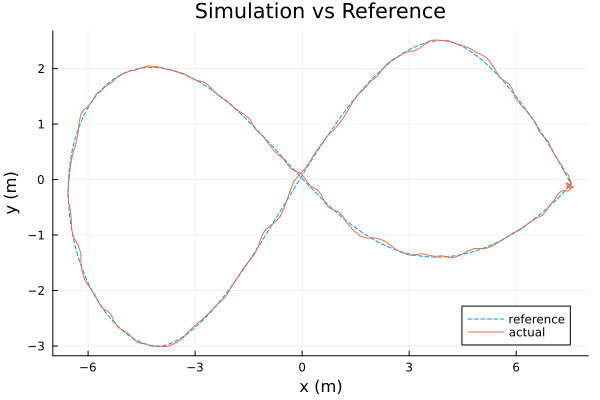

In [323]:
plot(Xr[1,:], Xr[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
display(plot!(Xmpc_sim[1,:], Xmpc_sim[2,:], label = "actual"))

# Add obstacles

In [ ]:
function stage_cost(params,x,u,k)
    xref, uref = params.Xref, params.Uref
    Q = params.Q
    R = params.R
    return 0.5*((x-xref[k])'*Q*(x-xref[k])) + 0.5*(u-uref[k])'*R*(u-uref[k])
end


In [181]:
function non_convex_mpc_obs(params,
                        xic,
                        X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                        U_ref_window::Vector{Vector{Float64}},
                        z0_window::Vector, # current state x 
                        N_mpc::Int64  # length of MPC window (horizon)
                        )::Vector{Float64} # return the first control command of the solved policy 
    idx = params.idx
    xg = X_ref_window[end]
    new_params = (xic = xic,
                  xg = xg,
                  Xref = X_ref_window,
                  Uref = U_ref_window,
                  dt =  params.dt,
                  N = N_mpc,
                  idx = idx,
                  Q =  params.Q,
                  R =  params.R,
                  Qf =  params.Qf,
                  Qobs = params.Qobs,
                  P_obs =  params.P_obs,
                  r =  params.r);
    #println("New params")
    Z_window = fmincon(ballbot_cost,
                       ballbot_equality_constraint,
                       ballbot_inequality_constraint_obs,
                       x_l_mpc,x_u_mpc,c_l_mpc,c_u_mpc,
                       z0_window,new_params, diff_type;
                       tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose);    
    # Return first control U 
    return Z_window[idx.u[1]]
end

non_convex_mpc_obs (generic function with 1 method)

In [182]:
Xref_trajop_free = FileIO.load("utils/ballbot_Xref_8_3Hz_free.jld2","Xref_8_3Hz_free")
Uref_trajop_free = FileIO.load("utils/ballbot_Uref_8_3Hz_free.jld2","Uref_8_3Hz_free");

In [225]:
# Optimization Parameters
dt = 1/3 # 10 Hz
nq = 5
nx = nq*2     # number of state
nu = 3     # number of controls
Tfinal = 25 # final time
N = Int(Tfinal/dt)+1   # number of time steps

# MPC window size 
N_mpc = 35 

# Cost matrices
Q = diagm(diagq)
Qf = 1*Q
R = 0.1*diagm(ones(nu))
#Qobs = 20*diagm(ones(2))

# indexing 
idx_mpc = create_idx(nx,nu,N_mpc);

In [251]:
P_obs = [[5, 1.75], [-5, -2.75]]
r = 0.4

0.4

In [252]:
# Primal bounds 
x_l_mpc = -Inf*ones(idx_mpc.nz)
x_u_mpc = Inf*ones(idx_mpc.nz)

# Inequality constraint bounds (this is what we do when we have no inequality constraints)
#nobs = length(P_obs)
c_l_mpc = -Inf*ones(N_mpc*nobs)
c_u_mpc = zeros(N_mpc*nobs)

verbose=true

true

In [276]:
# initial and goal states
x0 = Xref_trajop_free[1]*1
xg = Xref_trajop_free[end]*1

# Problem size and reference trajectory 
t_vec = 0:dt:((N-1)*dt)
X_ref = [Xref_trajop_free*1...,[xg for i = 1:2*N_mpc]...]
U_ref = [Uref_trajop_free*1...,[zeros(3) for i = 1:2*N_mpc]...]

# sim size and setup 
N_sim = N + N_mpc 
t_vec = 0:dt:((N_sim-1)*dt)
X_sim = [zeros(nx) for i = 1:N_sim]
X_sim[1] = x0 
U_sim = [zeros(nu) for i = 1:(N_sim-1)]

# Create params
params_mpc = (xic = x0,
              xg = xg,
              Xref = Xref,
              Uref = Uref,
              dt = h,
              N = idx_mpc.N,
              idx = idx_mpc,
              Q = Q,
              R = R,
              Qf = Qf,
              Qobs = Qobs,
              P_obs = P_obs,
              r = r);

# simulate 
@showprogress "simulating" for i = 1:N_sim-1 
    # Given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    U_ref_tilde = U_ref[i:i+N_mpc-1]
    z_0_w = zeros(idx_mpc.nz)
    for j in 1:(N_mpc-1)
        z_0_w[idx_mpc.x[j]] .= X_ref_tilde[j]
        z_0_w[idx_mpc.u[j]] .= U_ref_tilde[j]
    end
    z_0_w[idx_mpc.x[end]] .= X_ref_tilde[end];
    
    # Call non convex mpc controller with state estimate 
    #println("Non-convex MPC")
    U_sim[i] = non_convex_mpc_obs(params_mpc, X_sim[i], X_ref_tilde, U_ref_tilde, z_0_w, N_mpc)
    # Simulate one step 
    X_sim[i+1] = rk4(ballbot_model, X_sim[i], U_sim[i], h)
end

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints.......

simulating   2%|▊                                        |  ETA: 0:23:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.39e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   3%|█▏                                       |  ETA: 0:23:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.42e-01 5.36e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   3%|█▍                                       |  ETA: 0:23:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.30e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   4%|█▊                                       |  ETA: 0:22:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.21e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   5%|██▏                                      |  ETA: 0:22:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.11e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   6%|██▌                                      |  ETA: 0:21:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.26e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   7%|██▉                                      |  ETA: 0:21:49

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.34e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   8%|███▎                                     |  ETA: 0:21:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.36e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating   9%|███▋                                     |  ETA: 0:21:49

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.33e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  10%|███▉                                     |  ETA: 0:22:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.23e-01 5.23e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  10%|████▎                                    |  ETA: 0:23:37

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.41e-01 5.07e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  11%|████▋                                    |  ETA: 0:23:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.54e-01 5.10e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  12%|█████                                    |  ETA: 0:22:51

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


simulating  13%|█████▍                                   |  ETA: 0:22:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.37e-01 5.15e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  14%|█████▊                                   |  ETA: 0:21:53

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.28e-01 5.11e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  15%|██████                                   |  ETA: 0:21:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.18e-01 5.02e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  16%|██████▍                                  |  ETA: 0:21:00

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.07e-01 4.85e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  17%|██████▊                                  |  ETA: 0:20:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.79e-02 4.62e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  17%|███████▏                                 |  ETA: 0:20:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 4.32e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  18%|███████▌                                 |  ETA: 0:19:47

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 3.94e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  19%|███████▉                                 |  ETA: 0:19:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 3.48e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  20%|████████▎                                |  ETA: 0:19:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 2.93e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  21%|████████▌                                |  ETA: 0:18:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 2.29e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  22%|████████▉                                |  ETA: 0:18:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.38e-02 1.52e-03   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  23%|█████████▎                               |  ETA: 0:18:30

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.96e-02 6.92e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  23%|█████████▋                               |  ETA: 0:18:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.06e-01 3.66e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  24%|██████████                               |  ETA: 0:18:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.11e-01 2.03e-04   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  25%|██████████▍                              |  ETA: 0:18:02

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.12e-01 5.55e-17   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  26%|██████████▊                              |  ETA: 0:17:43

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 1.08e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  27%|███████████                              |  ETA: 0:17:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 9.76e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  28%|███████████▍                             |  ETA: 0:17:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 8.75e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  29%|███████████▊                             |  ETA: 0:16:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 7.61e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  30%|████████████▏                            |  ETA: 0:16:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 6.45e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  30%|████████████▌                            |  ETA: 0:16:08

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 5.32e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  31%|████████████▉                            |  ETA: 0:15:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 4.28e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  32%|█████████████▎                           |  ETA: 0:15:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 3.35e-02 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  33%|█████████████▌                           |  ETA: 0:15:15

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


simulating  34%|█████████████▉                           |  ETA: 0:14:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  35%|██████████████▎                          |  ETA: 0:14:43

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  36%|██████████████▋                          |  ETA: 0:14:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  37%|███████████████                          |  ETA: 0:14:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  37%|███████████████▍                         |  ETA: 0:13:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  38%|███████████████▋                         |  ETA: 0:13:41

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  39%|████████████████                         |  ETA: 0:13:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  40%|████████████████▍                        |  ETA: 0:13:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  41%|████████████████▊                        |  ETA: 0:12:56

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  42%|█████████████████▏                       |  ETA: 0:12:42

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  43%|█████████████████▌                       |  ETA: 0:12:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  43%|█████████████████▉                       |  ETA: 0:12:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  44%|██████████████████▏                      |  ETA: 0:12:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  45%|██████████████████▌                      |  ETA: 0:11:53

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  46%|██████████████████▉                      |  ETA: 0:11:40

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  47%|███████████████████▎                     |  ETA: 0:11:27

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  48%|███████████████████▋                     |  ETA: 0:11:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  49%|████████████████████                     |  ETA: 0:11:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  50%|████████████████████▍                    |  ETA: 0:10:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  50%|████████████████████▋                    |  ETA: 0:10:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  51%|█████████████████████                    |  ETA: 0:10:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  52%|█████████████████████▍                   |  ETA: 0:10:10

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  53%|█████████████████████▊                   |  ETA: 0:09:58

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  54%|██████████████████████▏                  |  ETA: 0:09:47

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


simulating  55%|██████████████████████▌                  |  ETA: 0:09:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  56%|██████████████████████▉                  |  ETA: 0:09:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  57%|███████████████████████▏                 |  ETA: 0:09:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  57%|███████████████████████▌                 |  ETA: 0:08:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  58%|███████████████████████▉                 |  ETA: 0:08:45

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  59%|████████████████████████▎                |  ETA: 0:08:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  60%|████████████████████████▋                |  ETA: 0:08:21

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  61%|█████████████████████████                |  ETA: 0:08:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  62%|█████████████████████████▍               |  ETA: 0:07:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  63%|█████████████████████████▋               |  ETA: 0:07:45

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  63%|██████████████████████████               |  ETA: 0:07:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  64%|██████████████████████████▍              |  ETA: 0:07:24

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  65%|██████████████████████████▊              |  ETA: 0:07:13

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  66%|███████████████████████████▏             |  ETA: 0:07:01

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  67%|███████████████████████████▌             |  ETA: 0:06:50

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  68%|███████████████████████████▊             |  ETA: 0:06:39

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  69%|████████████████████████████▏            |  ETA: 0:06:28

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  70%|████████████████████████████▌            |  ETA: 0:06:17

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  70%|████████████████████████████▉            |  ETA: 0:06:06

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  71%|█████████████████████████████▎           |  ETA: 0:05:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  72%|█████████████████████████████▋           |  ETA: 0:05:44

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  73%|██████████████████████████████           |  ETA: 0:05:44

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  74%|██████████████████████████████▎          |  ETA: 0:05:35

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  75%|██████████████████████████████▋          |  ETA: 0:05:26

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


simulating  76%|███████████████████████████████          |  ETA: 0:05:16

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  77%|███████████████████████████████▍         |  ETA: 0:05:05

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  77%|███████████████████████████████▊         |  ETA: 0:04:54

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  78%|████████████████████████████████▏        |  ETA: 0:04:43

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  79%|████████████████████████████████▌        |  ETA: 0:04:32

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  80%|████████████████████████████████▊        |  ETA: 0:04:20

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  81%|█████████████████████████████████▏       |  ETA: 0:04:09

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  82%|█████████████████████████████████▌       |  ETA: 0:03:57

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  83%|█████████████████████████████████▉       |  ETA: 0:03:46

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  83%|██████████████████████████████████▎      |  ETA: 0:03:34

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  84%|██████████████████████████████████▋      |  ETA: 0:03:23

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  85%|███████████████████████████████████      |  ETA: 0:03:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  86%|███████████████████████████████████▎     |  ETA: 0:02:59

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  87%|███████████████████████████████████▋     |  ETA: 0:02:48

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  88%|████████████████████████████████████     |  ETA: 0:02:37

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  89%|████████████████████████████████████▍    |  ETA: 0:02:25

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  90%|████████████████████████████████████▊    |  ETA: 0:02:14

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  90%|█████████████████████████████████████▏   |  ETA: 0:02:03

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  91%|█████████████████████████████████████▍   |  ETA: 0:01:52

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  92%|█████████████████████████████████████▊   |  ETA: 0:01:40

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  93%|██████████████████████████████████████▏  |  ETA: 0:01:29

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  94%|██████████████████████████████████████▌  |  ETA: 0:01:18

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  95%|██████████████████████████████████████▉  |  ETA: 0:01:07

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  96%|███████████████████████████████████████▎ |  ETA: 0:00:56

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  97%|███████████████████████████████████████▋ |  ETA: 0:00:45

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------


simulating  97%|███████████████████████████████████████▉ |  ETA: 0:00:33

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  98%|████████████████████████████████████████▎|  ETA: 0:00:22

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating  99%|████████████████████████████████████████▋|  ETA: 0:00:11

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

simulating 100%|█████████████████████████████████████████| Time: 0:21:14


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:   211970
Number of nonzeros in inequality constraint Jacobian.:    41360
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      517
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      410
Total number of inequality constraints...............:       80
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.63e-01 0.00e+00   0.0 0.00e+00    -  0.00e+00 0.00e+00  

In [277]:
Xmpc_sim = hcat(X_sim...)
Umpc_sim = hcat(U_sim...);

In [278]:
Xr = hcat(Xref_trajop_free...)

10×76 Matrix{Float64}:
 10.0          10.0396      9.99705    …  10.0366      9.9954
  0.0          -0.0428175  -0.0270434     -0.136147   -0.175122
 -6.77914e-30  -0.0567639  -0.116039      -0.058627    4.83703e-28
 -6.80562e-30   0.040889    0.0771172     -0.0382518   3.02996e-28
 -4.61829e-28  -0.395908   -0.769829       0.346045    2.18181e-28
  0.0           0.308848   -0.465501   …  -0.32307    -2.92979e-29
  0.0          -0.329291    0.353382      -0.30083    -1.03351e-29
  0.0          -0.452296   -0.0303079      0.467475    1.31727e-28
 -9.82889e-30   0.349661   -0.0386116      0.325766   -3.27925e-28
  0.0          -2.37161     0.101841      -2.07        3.95617e-29

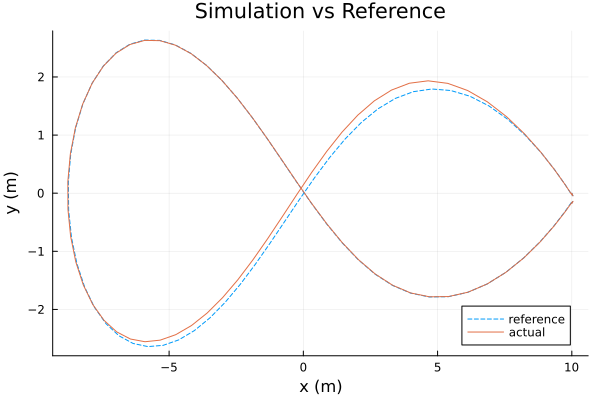

In [279]:
plot(Xr[1,:], Xr[2,:], ls = :dash, label = "reference",
         xlabel = "x (m)", ylabel = "y (m)", title = "Simulation vs Reference")
display(plot!(Xmpc_sim[1,:], Xmpc_sim[2,:], label = "actual"))

In [262]:
Xmpc_sim[1,9]

6.854768104016045

In [263]:
Xmpc_sim[2,9]

1.571627721366535

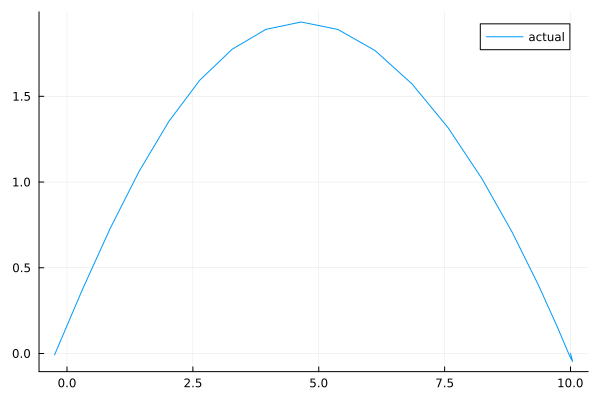

In [264]:
plot(Xmpc_sim[1,1:20], Xmpc_sim[2,1:20], label = "actual")

In [265]:
Xs = [SVector{5}(x[1:5]) for x in X_sim];

In [266]:
# Uncomment for upload animation to visualizer
animation = mc.Animation(mvis, t_vec, Xs)
setanimation!(mvis, animation)

In [272]:
P_bot = dc.create_rect_prism(0.5, 0.5, 0.5)[1]
P_bot.r = [1.75,-5,0.5]
P_top = dc.create_rect_prism(0.5, 0.5, 0.5)[1]
P_top.r = [-2.75,5,0.5]

P_obs_dc = [P_bot, P_top];

In [273]:
coll = Random.shuffle(range(HSVA(0,0.5,.75,1.0), stop=HSVA(-360,0.5,.75,1.0), length=9))
for i = 1:2
    name = "P" * string(i)
    dc.build_primitive!(mvis, P_obs_dc[i], name; α = 1.0,color = coll[i])
    dc.update_pose!(mvis[name], P_obs_dc[i])
end